# FCN：图像语义分割的一种框架
全卷积网络（Fully Convolutional Networks，FCN）是UC Berkeley的Jonathan Long等人于2015年在Fully Convolutional Networks for Semantic Segmentation一文中提出的用于图像语义分割的一种框架。

FCN是首个端到端（end to end）进行像素级（pixel level）预测的全卷积网络。

<img src="./image/pic1.png" width = 60% />

### 语义分割
在具体介绍FCN之前，首先介绍何为语义分割：

图像语义分割（semantic segmentation）是图像处理和机器视觉技术中关于图像理解的重要一环，AI领域中一个重要分支，常被应用于人脸识别、物体检测、医学影像、卫星图像分析、自动驾驶感知等领域。

语义分割的目的是对图像中每个像素点进行分类。与普通的分类任务只输出某个类别不同，语义分割任务输出与输入大小相同的图像，输出图像的每个像素对应了输入图像每个像素的类别。语义在图像领域指的是图像的内容，对图片意思的理解，下图是一些语义分割的实例：

<img src="./image/pic2.png" width = 30% />

### 模型简介
FCN主要用用于图像分割领域，是一种端到端的分割方法，是深度学习应用在图像语义分割的开山之作。通过进行像素级的预测直接得出与原图大小相等的label map。因FCN丢弃全连接层替换为全卷积层，网络所有层均为卷积层，故称为全卷积网络。

全卷积神经网络主要使用以下三种技术：

1. 卷积化（Convolutional）
使用VGG-16作为FCN的backbone。VGG-16的输入为224*224的RGB图像，输出为1000个预测值。VGG-16只能接受固定大小的输入，丢弃了空间坐标，产生非空间输出。VGG-16中共有三个全连接层，全连接层也可视为带有覆盖整个区域的卷积。将全连接层转换为卷积层能使网络输出由一维非空间输出变为二维矩阵，利用输出能生成输入图片映射的heatmap。

<img src="./image/pic3.png" width = 50% />


2. 上采样（Upsample）
在卷积过程的卷积操作和池化操作会使得特征图的尺寸变小，为得到原图的大小的稠密图像预测，需要对得到的特征图进行上采样操作。使用双线性插值的参数来初始化上采样逆卷积的参数，后通过反向传播来学习非线性上采样。在网络中执行上采样，以通过像素损失的反向传播进行端到端的学习。

<img src="./image/pic4.png" width = 50% />


3. 跳跃结构（Skip Layer）
利用上采样技巧对最后一层的特征图进行上采样得到原图大小的分割是步长为32像素的预测，称之为FCN-32s。由于最后一层的特征图太小，损失过多细节，采用skips结构将更具有全局信息的最后一层预测和更浅层的预测结合，使预测结果获取更多的局部细节。将底层（stride 32）的预测（FCN-32s）进行2倍的上采样得到原尺寸的图像，并与从pool4层（stride 16）进行的预测融合起来（相加），这一部分的网络被称为FCN-16s。随后将这一部分的预测再进行一次2倍的上采样并与从pool3层得到的预测融合起来，这一部分的网络被称为FCN-8s。 Skips结构将深层的全局信息与浅层的局部信息相结合。

<img src="./image/pic5.png" width = 60% />

### 网络特点
1. 不含全连接层(fc)的全卷积(fully conv)网络，可适应任意尺寸输入。  
2. 增大数据尺寸的反卷积(deconv)层，能够输出精细的结果。  
3. 结合不同深度层结果的跳级(skip)结构，同时确保鲁棒性和精确性。

## 数据处理
开始实验前，需确保本地已经安装Python环境及MindSpore Vision套件。

### 数据准备
本案例使用PASCAL VOC 2012数据集与SBD数据集混合训练与评估，请从官网下载数据集之后按照如下格式进行放置。

```
.dataset/
    └──benchmark_RELEASE
        └──dataset
            └──train.txt                  8498行图像的名字索引
            └──cls                        11355全是mat文件
            └──img                        11355全是jpg图像文件（隶属于voc的JPEGImage文件夹下的17125张jpg图像）
            └──inst                       11355全是mat文件
            └──val.txt                    2857行图像的名字索引
    └──VOCdevkit
        └── VOC2012
            ├── Annotations               所有的图像标注信息(XML文件)
            ├── ImageSets    
            │   ├── Action                人的行为动作图像信息
            │   ├── Layout                人的各个部位图像信息
            │   │
            │   ├── Main                  目标检测分类图像信息
            │   │     ├── train.txt       训练集(5717)
            │   │     ├── val.txt         验证集(5823)
            │   │     └── trainval.txt    训练集+验证集(11540)
            │   │
            │   └── Segmentation          目标分割图像信息
            │         ├── train.txt       训练集(1464)
            │         ├── val.txt         验证集(1449)
            │         └── trainval.txt    训练集+验证集(2913)
            │ 
            ├── JPEGImages                所有图像文件
            ├── SegmentationClass         语义分割png图（基于类别）
            └── SegmentationObject        实例分割png图（基于目标）


```

### 数据预处理
导入模块需要用到部分src中的文件，校验时请保持该notebook与src文件夹平级。由于PASCAL VOC 2012数据集中图像的分辨率大多不一致，无法放在一个tensor中，故输入前需做标准化处理。

In [7]:
from src.data.get_data_list import get_data_list

dataset_path = "dataset"  
#将数据集转化为标准形式 
get_data_list(dataset_path)

converting voc color png to gray png ...
converting done.
generating voc train list success.
generating voc val list success.
converting sbd annotations to png ...
converting done
generating voc train aug list success.


### 数据加载
将PASCAL VOC 2012数据集与SDB数据集进行混合。

In [10]:

from src.data.build_seg_data import build_data ##TODO 改名

# VOC数据集的根目录
data_root = "" #TODO  为什么目录有问题

# 分割数据标注文件的位置
data_lst = 'dataset/vocaug_train_lst.txt' 

# 存放生成MindRecord数据的路径
dst_path = 'dataset/mindname.mindrecord' #*
# print(os.path.join(data_root, "wee.jpg"))
# mindrecord超参数
num_shards = 1

# 是否打乱 
shuffle = True

build_data(data_root, data_lst, dst_path, num_shards, shuffle)

number of samples: 10582
number of samples written: 1000
number of samples written: 2000
number of samples written: 3000
number of samples written: 4000
number of samples written: 5000
number of samples written: 6000
number of samples written: 7000
number of samples written: 8000
number of samples written: 9000
number of samples written: 10000
number of samples written: 10582


In [1]:
from src.data import dataset as data_generator 
#创建数据集的参数
image_mean = [103.53, 116.28, 123.675]
image_std = [57.375, 57.120, 58.395]
data_lst = 'dataset/vocaug_train_lst.txt'
data_file = "dataset/mindname.mindrecord"
#记得改大
train_batch_size = 4
crop_size = 512
min_scale = 0.5
max_scale = 2.0
ignore_label = 255
num_classes = 21 
rank = None
group_size = None

# 构建数据集 
dataset = data_generator.SegDataset(image_mean=image_mean,
                                        image_std=image_std,
                                        data_file=data_file,
                                        batch_size=train_batch_size,
                                        crop_size=crop_size,
                                        max_scale=max_scale,
                                        min_scale=min_scale,
                                        ignore_label=ignore_label,
                                        num_classes=num_classes,
                                        num_readers=2,
                                        num_parallel_calls=4,
                                        shard_id=rank,
                                        shard_num=group_size)

dataset = dataset.get_dataset(repeat=1)


### 训练集可视化
运行以下代码观察载入的数据集图片。

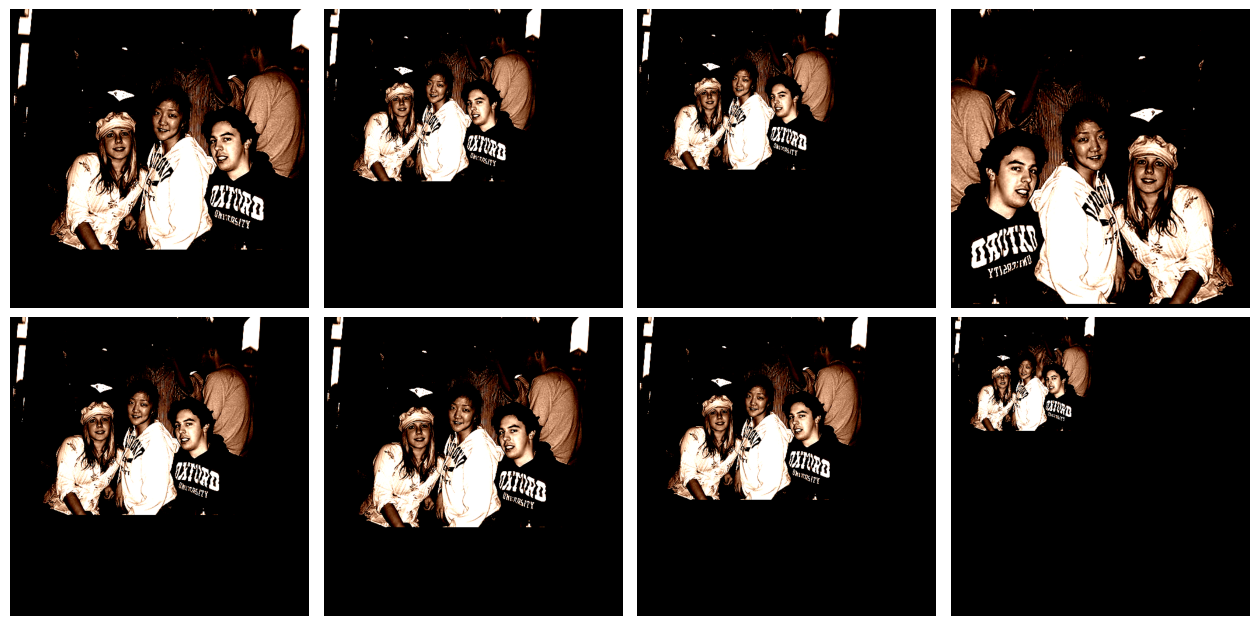

In [14]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))

# 展示图片供参考
for i in range(1, 9):
    plt.subplot(2, 4, i)
    show_data = next(dataset.create_dict_iterator())
    show_images = show_data["data"].asnumpy()
    show_images = np.clip(show_images,0,1)
    # 将图片转换HWC格式后显示
    plt.imshow(show_images[0].transpose(1,2,0))
    plt.axis("off")
    plt.subplots_adjust(wspace=0.05, hspace=0)

## 网络构建

### 网络流程
FCN网络的流程如下图所示：

1. 输入图像image，经过pool1池化后，尺寸变为原始尺寸的1/2。
2. 经过pool2池化，尺寸变为原始尺寸的1/4。
3. 接着经过pool3、pool4、pool5池化，大小分别变为原始尺寸的1/8、1/16、1/32。
4. 经过conv6-7卷积，输出的尺寸依然是原图的1/32。
5. FCN-32s是最后使用反卷积，使得输出图像大小与输入图像相同。
6. FCN-16s是将conv7的输出进行反卷积，使其尺寸扩大两倍至原图的1/16，并将其与pool4输出的特征图进行融合，后通过反卷积扩大到原始尺寸。
7. FCN-8s是将conv7的输出进行反卷积扩大4倍，将pool4输出的特征图反卷积扩大2倍，并将pool3输出特征图拿出，三者融合后通反卷积扩大到原始尺寸。

<img src="./image/pic6.png" style="zoom:85%;" />

使用以下代码构建FCN-8s网络。

In [2]:
import mindspore as ms
import mindspore.nn as nn
from mindspore.ops import operations as P
ms.set_seed(23)

# VGG Cell
class conv(nn.Cell):
    # 输入维度, 输出维度, 卷积层数
    def __init__(self, in_ch, out_ch, num):
        super(conv, self).__init__()
        conv_list = [nn.SequentialCell(nn.Conv2d(out_ch, out_ch, 3, weight_init='xavier_uniform'),
                                       nn.BatchNorm2d(out_ch), nn.ReLU()) for i in range(num - 1)]
        self.conv = nn.SequentialCell([nn.Conv2d(in_ch, out_ch, 3, weight_init='xavier_uniform'),
                                             nn.BatchNorm2d(out_ch), nn.ReLU()] + conv_list)
    def construct(self, x):
        x = self.conv(x)
        return x

class FCN8s(nn.Cell):
    def __init__(self, n_class):
        super().__init__()
        self.n_class = n_class
        # VGG BackBone
        self.conv1 = conv(3, 64, 2)
        # [N,3,224,224]->[N,64,224,224]
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # [N,64,224,224]->[N,64,112,112]

        self.conv2 = conv(64, 128, 2)
        # [N,64,112,112]->[N,128,112,112]
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # [N,128,112,112]->[N,128,56,56]


        self.conv3 = conv(128, 256, 3)
        # [N,128,56,56]->[N,256,56,56]
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # [N,256,56,56]->[N,256,28,28]

        self.conv4 = conv(256, 512, 3)
        # [N,256,28,28]->[N,512,28,28]
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        # [N,512,28,28]->[N,512,14,14]

        self.conv5 = conv(512, 512, 3)
        # 维数不变
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        # [N,512,14,14]->[N,512,7,7]
        
        self.conv6 = nn.SequentialCell(
            nn.Conv2d(in_channels=512, out_channels=4096,
                      kernel_size=7, weight_init='xavier_uniform'), 
            nn.BatchNorm2d(4096),
            nn.ReLU(),
        )
        self.conv7 = nn.SequentialCell(
            nn.Conv2d(in_channels=4096, out_channels=4096,
                      kernel_size=1, weight_init='xavier_uniform'),
            nn.BatchNorm2d(4096),
            nn.ReLU(),
        )
        self.score_fr = nn.Conv2d(in_channels=4096, out_channels=self.n_class,
                                   kernel_size=1, weight_init='xavier_uniform')
        
        self.upscore2 = nn.Conv2dTranspose(in_channels=self.n_class, out_channels=self.n_class,
                                           kernel_size=4, stride=2, weight_init='xavier_uniform')
        self.score_pool4 = nn.Conv2d(in_channels=512, out_channels=self.n_class,
                                     kernel_size=1, weight_init='xavier_uniform')
        self.upscore_pool4 = nn.Conv2dTranspose(in_channels=self.n_class, out_channels=self.n_class,
                                                kernel_size=4, stride=2, weight_init='xavier_uniform')
        self.score_pool3 = nn.Conv2d(in_channels=256, out_channels=self.n_class,
                                     kernel_size=1, weight_init='xavier_uniform')
        self.upscore8 = nn.Conv2dTranspose(in_channels=self.n_class, out_channels=self.n_class,
                                           kernel_size=16, stride=8, weight_init='xavier_uniform')
        
        self.shape = P.Shape()
        self.cast = P.Cast()
        self.add1 = P.Add()
        self.add2 = P.Add()

    # 前向过程
    def construct(self, x):
        # 特征提取 
        x1 = self.conv1(x)
        p1 = self.pool1(x1)
        x2 = self.conv2(p1)
        p2 = self.pool2(x2)
        x3 = self.conv3(p2)
        p3 = self.pool3(x3)
        x4 = self.conv4(p3)
        p4 = self.pool4(x4)
        x5 = self.conv5(p4)
        p5 = self.pool5(x5)

        x6 = self.conv6(p5)
        x7 = self.conv7(x6)

        # 上采样
        sf = self.score_fr(x7)
        u2 = self.upscore2(sf)

        s4 = self.score_pool4(p4)
        f4 = self.add1(s4, u2)
        u4 = self.upscore_pool4(f4)

        s3 = self.score_pool3(p3)
        f3 = self.add2(s3, u4)
        out = self.upscore8(f3)

        return out

## 训练准备
### 导入VGG-16部分预训练权重

FCN使用VGG-16作为骨干网络，用于实现图像编码。使用下面代码导入VGG-16预训练模型的部分预训练权重。

In [16]:
from mindspore.train.serialization import load_checkpoint, load_param_into_net
def Load_vgg16():
    ckpt_vgg16 = "./vgg16_predtrain.ckpt"
    param_vgg = load_checkpoint(ckpt_vgg16)
    is_model_zoo_vgg16 = "layers.0.weight" in param_vgg
    if is_model_zoo_vgg16:
        _is_bn_used = "layers.1.gamma" in param_vgg
        _is_imagenet_used = param_vgg['classifier.6.bias'].shape == (1000,)
        if not _is_bn_used or not _is_imagenet_used:
            raise Exception("Please use the vgg16 checkpoint which use BN and trained by ImageNet dataset.")
    idx = 0
    param_dict = {}
    for layer_id in range(1, 6):
        sub_layer_num = 2 if layer_id < 3 else 3
        for sub_layer_id in range(sub_layer_num):
            # conv param
            y_weight = 'conv{}.{}.weight'.format(layer_id, 3 * sub_layer_id)
            x_weight = 'vgg16_feature_extractor.conv{}_{}.0.weight'.format(layer_id, sub_layer_id + 1)
            if is_model_zoo_vgg16:
                x_weight = 'layers.{}.weight'.format(idx)
            param_dict[y_weight] = param_vgg[x_weight]
            # BatchNorm param
            y_gamma = 'conv{}.{}.gamma'.format(layer_id, 3 * sub_layer_id + 1)
            y_beta = 'conv{}.{}.beta'.format(layer_id, 3 * sub_layer_id + 1)
            x_gamma = 'vgg16_feature_extractor.conv{}_{}.1.gamma'.format(layer_id, sub_layer_id + 1)
            x_beta = 'vgg16_feature_extractor.conv{}_{}.1.beta'.format(layer_id, sub_layer_id + 1)
            if is_model_zoo_vgg16:
                x_gamma = 'layers.{}.gamma'.format(idx + 1)
                x_beta = 'layers.{}.beta'.format(idx + 1)
            param_dict[y_gamma] = param_vgg[x_gamma]
            param_dict[y_beta] = param_vgg[x_beta]
            idx += 3
        idx += 1
    load_param_into_net(net, param_dict)

### 余弦退火调整学习率（ CosineAnnealingLR）设置
以余弦函数为周期，并在每个周期最大值时重新设置学习率。以初始学习率为最大学习率，以$2 ∗ T m a x 2*Tmax 2∗Tmax$为周期，在一个周期内先下降，后上升。使得前几个周期内的学习率较小，在较小的学习率的预热下模型将逐步趋于稳定，当模型较为稳定后便使用预先设置的学习率进行训练，这有利于加快模型的收敛速度，模型效果更佳。


In [17]:
import math
from collections import Counter
import numpy as np

class _LinearWarmUp():
    def __init__(self, lr, warmup_epochs, steps_per_epoch, warmup_init_lr=0):
        self.base_lr = lr
        self.warmup_init_lr = warmup_init_lr
        self.warmup_steps = int(warmup_epochs * steps_per_epoch)

    def get_warmup_steps(self):
        return self.warmup_steps

    def get_lr(self, current_step):
        lr_inc = (float(self.base_lr) - float(self.warmup_init_lr)) / float(self.warmup_steps)
        lr = float(self.warmup_init_lr) + lr_inc * current_step
        return lr
    
class CosineAnnealingLR():
    def __init__(self, lr, T_max, steps_per_epoch, max_epoch, warmup_epochs=0, eta_min=0):
        self.base_lr = lr
        self.steps_per_epoch = steps_per_epoch
        self.total_steps = int(max_epoch * steps_per_epoch)
        self.T_max = T_max
        self.eta_min = eta_min
        self.warmup = _LinearWarmUp(lr, warmup_epochs, steps_per_epoch)

    def get_lr(self):
        warmup_steps = self.warmup.get_warmup_steps()

        lr_each_step = []
        current_lr = self.base_lr
        for i in range(self.total_steps):
            if i < warmup_steps:
                lr = self.warmup.get_lr(i+1)
            else:
                cur_ep = i // self.steps_per_epoch
                if i % self.steps_per_epoch == 0 and i > 0:
                    current_lr = self.eta_min + \
                                 (self.base_lr - self.eta_min) * (1. + math.cos(math.pi*cur_ep / self.T_max)) / 2

                lr = current_lr
            lr_each_step.append(lr)

        return np.array(lr_each_step).astype(np.float32)

### 损失函数
语义分割是对图像中每个像素点进行分类，仍是分类问题，故损失函数选择交叉熵损失函数。自定义了损失函数的类来计算FCN网络输出与mask之间的交叉熵损失。

具体代码如下：

In [18]:
from mindspore import Tensor
import mindspore.common.dtype as mstype
import mindspore.nn as nn
from mindspore.ops import operations as P

##TODO 可以用文件里那个
class SoftmaxCrossEntropyLoss(nn.Cell):
    def __init__(self, num_cls=21, ignore_label=255, device_num=8):
        super(SoftmaxCrossEntropyLoss, self).__init__()
        self.one_hot = P.OneHot(axis=-1)
        self.on_value = Tensor(1.0, mstype.float32)
        self.off_value = Tensor(0.0, mstype.float32)
        self.cast = P.Cast()
        self.ce = nn.SoftmaxCrossEntropyWithLogits()
        self.not_equal = P.NotEqual()
        self.num_cls = num_cls
        self.ignore_label = ignore_label
        self.mul = P.Mul()
        self.sum = P.ReduceSum(False)
        self.div = P.RealDiv()
        self.transpose = P.Transpose()
        self.reshape = P.Reshape()
        self.transpose.shard(((1, 1, 1, device_num),))

    def construct(self, logits, labels):
        labels_int = self.cast(labels, mstype.int32)
        labels_int = self.reshape(labels_int, (-1,))
        logits_ = self.transpose(logits, (0, 2, 3, 1))
        logits_ = self.reshape(logits_, (-1, self.num_cls))
        weights = self.not_equal(labels_int, self.ignore_label)
        weights = self.cast(weights, mstype.float32)
        one_hot_labels = self.one_hot(labels_int, self.num_cls, self.on_value, self.off_value)
        logits_ = self.cast(logits_, mstype.float32)
        loss = self.ce(logits_, one_hot_labels)
        loss = self.mul(weights, loss)
        loss = self.div(self.sum(loss), self.sum(weights))
        return loss

## 模型训练

导入VGG-16预训练参数后，实例化损失函数、优化器，使用Model接口编译网络，训练FCN-8s网络。

In [ ]:
from mindspore import context, Tensor
from mindspore.train.model import Model
from mindspore.context import ParallelMode
import mindspore.nn as nn
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig
from mindspore.train.callback import LossMonitor, TimeMonitor

# 初始化模型结构
net = FCN8s(n_class=num_classes)

# 导入vgg16预训练参数
Load_vgg16()

# 计算学习率
base_lr = 0.0005
train_epochs = 280   #方便展示
iters_per_epoch = dataset.get_dataset_size()

lr_scheduler = CosineAnnealingLR(base_lr,
                                 train_epochs,
                                 iters_per_epoch,
                                 train_epochs,
                                 warmup_epochs=0,
                                 eta_min=0)
lr = Tensor(lr_scheduler.get_lr())

# 损失函数
loss_scale = 1024
loss_ = SoftmaxCrossEntropyLoss(num_classes, ignore_label, device_num=1)

# 优化器
optimizer = nn.Momentum(params=net.trainable_params(), learning_rate=lr, momentum=0.9, weight_decay=0.0001)

# 初始化模型
model = Model(net, loss_fn=loss_, optimizer=optimizer)

# 设置ckpt文件保存的参数
time_cb = TimeMonitor(data_size=iters_per_epoch)
loss_cb = LossMonitor()
cbs = [time_cb, loss_cb]
save_steps = 330
keep_checkpoint_max = 5
config_ck = CheckpointConfig(save_checkpoint_steps=save_steps,
                             keep_checkpoint_max=keep_checkpoint_max)
ckpoint_cb = ModelCheckpoint(prefix="FCN8s", 
                             directory="./ckpt", 
                             config=config_ck)
cbs.append(ckpoint_cb)

#训练
model.train(train_epochs, dataset, callbacks=cbs)

[WARNING] ME(65974:139950993332032,MainProcess):2022-10-07-01:15:17.106.985 [mindspore/train/serialization.py:712] For 'load_param_into_net', 81 parameters in the 'net' are not loaded, because they are not in the 'parameter_dict', please check whether the network structure is consistent when training and loading checkpoint.
[WARNING] ME(65974:139950993332032,MainProcess):2022-10-07-01:15:17.107.497 [mindspore/train/serialization.py:714] conv1.conv.0.weight is not loaded.
[WARNING] ME(65974:139950993332032,MainProcess):2022-10-07-01:15:17.107.807 [mindspore/train/serialization.py:714] conv1.conv.1.moving_mean is not loaded.
[WARNING] ME(65974:139950993332032,MainProcess):2022-10-07-01:15:17.108.090 [mindspore/train/serialization.py:714] conv1.conv.1.moving_variance is not loaded.
[WARNING] ME(65974:139950993332032,MainProcess):2022-10-07-01:15:17.108.331 [mindspore/train/serialization.py:714] conv1.conv.1.gamma is not loaded.
[WARNING] ME(65974:139950993332032,MainProcess):2022-10-07-01

[WARNING] ME(65974:139950993332032,MainProcess):2022-10-07-01:15:17.121.671 [mindspore/train/serialization.py:714] conv5.conv.1.moving_variance is not loaded.
[WARNING] ME(65974:139950993332032,MainProcess):2022-10-07-01:15:17.121.875 [mindspore/train/serialization.py:714] conv5.conv.1.gamma is not loaded.
[WARNING] ME(65974:139950993332032,MainProcess):2022-10-07-01:15:17.122.077 [mindspore/train/serialization.py:714] conv5.conv.1.beta is not loaded.
[WARNING] ME(65974:139950993332032,MainProcess):2022-10-07-01:15:17.122.276 [mindspore/train/serialization.py:714] conv5.conv.3.0.weight is not loaded.
[WARNING] ME(65974:139950993332032,MainProcess):2022-10-07-01:15:17.122.480 [mindspore/train/serialization.py:714] conv5.conv.3.1.moving_mean is not loaded.
[WARNING] ME(65974:139950993332032,MainProcess):2022-10-07-01:15:17.122.694 [mindspore/train/serialization.py:714] conv5.conv.3.1.moving_variance is not loaded.
[WARNING] ME(65974:139950993332032,MainProcess):2022-10-07-01:15:17.122.90

epoch: 1 step: 2645, loss is 0.8293703198432922
Train epoch time: 605395.401 ms, per step time: 228.883 ms
epoch: 2 step: 2645, loss is 1.3637114763259888
Train epoch time: 600291.392 ms, per step time: 226.953 ms
epoch: 3 step: 2645, loss is 0.8388709425926208
Train epoch time: 600685.416 ms, per step time: 227.102 ms
epoch: 4 step: 2645, loss is 0.8886798620223999
Train epoch time: 600721.011 ms, per step time: 227.116 ms
epoch: 5 step: 2645, loss is 1.1938129663467407
Train epoch time: 600771.019 ms, per step time: 227.135 ms
epoch: 6 step: 2645, loss is 1.682997226715088
Train epoch time: 600910.538 ms, per step time: 227.187 ms
epoch: 7 step: 2645, loss is 1.5033059120178223
Train epoch time: 600950.653 ms, per step time: 227.203 ms
epoch: 8 step: 2645, loss is 0.46118783950805664
Train epoch time: 600966.918 ms, per step time: 227.209 ms
epoch: 9 step: 2645, loss is 0.6872029900550842
Train epoch time: 601001.752 ms, per step time: 227.222 ms
epoch: 10 step: 2645, loss is 0.90565

epoch: 77 step: 2645, loss is 0.7213545441627502
Train epoch time: 607521.461 ms, per step time: 229.687 ms
epoch: 78 step: 2645, loss is 0.569140613079071
Train epoch time: 611992.599 ms, per step time: 231.377 ms
epoch: 79 step: 2645, loss is 0.247415229678154
Train epoch time: 615678.541 ms, per step time: 232.771 ms
epoch: 80 step: 2645, loss is 0.2218829095363617
Train epoch time: 622740.724 ms, per step time: 235.441 ms
epoch: 81 step: 2645, loss is 0.5160104632377625
Train epoch time: 617802.820 ms, per step time: 233.574 ms
epoch: 82 step: 2645, loss is 0.46306881308555603
Train epoch time: 616496.449 ms, per step time: 233.080 ms
epoch: 83 step: 2645, loss is 0.6085172295570374
Train epoch time: 615219.486 ms, per step time: 232.597 ms
epoch: 84 step: 2645, loss is 0.12353962659835815
Train epoch time: 612128.891 ms, per step time: 231.429 ms
epoch: 85 step: 2645, loss is 0.23457281291484833
Train epoch time: 601238.721 ms, per step time: 227.311 ms
epoch: 86 step: 2645, loss 

Train epoch time: 601632.387 ms, per step time: 227.460 ms
epoch: 153 step: 2645, loss is 0.10649199038743973
Train epoch time: 601647.452 ms, per step time: 227.466 ms
epoch: 154 step: 2645, loss is 0.23875176906585693
Train epoch time: 601604.755 ms, per step time: 227.450 ms
epoch: 155 step: 2645, loss is 0.16918566823005676
Train epoch time: 601650.028 ms, per step time: 227.467 ms
epoch: 156 step: 2645, loss is 0.2277495563030243
Train epoch time: 601860.626 ms, per step time: 227.547 ms
epoch: 157 step: 2645, loss is 0.06465387344360352
Train epoch time: 601943.753 ms, per step time: 227.578 ms
epoch: 158 step: 2645, loss is 0.051752492785453796
Train epoch time: 601950.196 ms, per step time: 227.580 ms
epoch: 159 step: 2645, loss is 0.1838439255952835
Train epoch time: 601907.857 ms, per step time: 227.564 ms
epoch: 160 step: 2645, loss is 0.1252061128616333
Train epoch time: 601979.386 ms, per step time: 227.591 ms
epoch: 161 step: 2645, loss is 0.3308771252632141
Train epoch t

Train epoch time: 601403.533 ms, per step time: 227.374 ms
epoch: 228 step: 2645, loss is 0.13817335665225983
Train epoch time: 601449.565 ms, per step time: 227.391 ms
epoch: 229 step: 2645, loss is 0.0859471932053566
Train epoch time: 601457.410 ms, per step time: 227.394 ms
epoch: 230 step: 2645, loss is 0.09982256591320038
Train epoch time: 601462.850 ms, per step time: 227.396 ms
epoch: 231 step: 2645, loss is 0.10937195271253586
Train epoch time: 601421.678 ms, per step time: 227.381 ms
epoch: 232 step: 2645, loss is 0.10354654490947723
Train epoch time: 601476.581 ms, per step time: 227.401 ms
epoch: 233 step: 2645, loss is 0.12855254113674164
Train epoch time: 601502.137 ms, per step time: 227.411 ms
epoch: 234 step: 2645, loss is 0.20770379900932312
Train epoch time: 601413.946 ms, per step time: 227.378 ms
epoch: 235 step: 2645, loss is 0.33876919746398926
Train epoch time: 601509.720 ms, per step time: 227.414 ms
epoch: 236 step: 2645, loss is 0.07965490221977234
Train epoch

## 模型预测

In [15]:
# 设置图像长宽
def resize_long(img, long_size=512):
    h, w, _ = img.shape
    if h > w:
        new_h = long_size
        new_w = int(1.0 * long_size * w / h)
    else:
        new_w = long_size
        new_h = int(1.0 * long_size * h / w)
    imo = cv2.resize(img, (new_w, new_h))
    return imo


# 图像增强    
def pre_process(img_, crop_size=512):
    # resize
    img_ = resize_long(img_, crop_size)
    resize_h, resize_w, _ = img_.shape

    # mean, std
    
    image_mean = [103.53, 116.28, 123.675]
    image_std = [57.375, 57.120, 58.395]
    image_mean = np.array(image_mean)
    image_std = np.array(image_std)
    img_ = (img_ - image_mean) / image_std

    # pad to crop_size
    pad_h = crop_size - img_.shape[0]
    pad_w = crop_size - img_.shape[1]
    if pad_h > 0 or pad_w > 0:
        img_ = cv2.copyMakeBorder(img_, 0, pad_h, 0, pad_w, cv2.BORDER_CONSTANT, value=0)

    # hwc to chw
    img_ = img_.transpose((2, 0, 1))
    return img_, resize_h, resize_w

# 对每个batch进行预测
def eval_batch(eval_net, img_lst, crop_size=512, flip=True):
    result_lst = []
    batch_size = len(img_lst)
    batch_img = np.zeros((eval_batch_size, 3, crop_size, crop_size), dtype=np.float32)
    resize_hw = []
    for l in range(batch_size):
        img_ = img_lst[l]
        img_, resize_h, resize_w = pre_process(img_, crop_size)
        batch_img[l] = img_
        resize_hw.append([resize_h, resize_w])

    batch_img = np.ascontiguousarray(batch_img)
    net_out = eval_net(Tensor(batch_img, mstype.float32))
    net_out = net_out.asnumpy()

    if flip:
        # 左右翻转图片
        batch_img = batch_img[:, :, :, ::-1]
        net_out_flip = eval_net(Tensor(batch_img, mstype.float32))
        net_out += net_out_flip.asnumpy()[:, :, :, ::-1]

    for bs in range(batch_size):
        probs_ = net_out[bs][:, :resize_hw[bs][0], :resize_hw[bs][1]].transpose((1, 2, 0))
        ori_h, ori_w = img_lst[bs].shape[0], img_lst[bs].shape[1]
        # 改回原图大小
        probs_ = cv2.resize(probs_.astype(np.float32), (ori_w, ori_h))
        result_lst.append(probs_)

    return result_lst

# 综合不同放大倍率下的预测结果
def eval_batch_scales(eval_net, img_lst, scales,
                      base_crop_size=512, flip=True):
    sizes_ = [int((base_crop_size - 1) * sc) + 1 for sc in scales]
    probs_lst = eval_batch(eval_net, img_lst, crop_size=sizes_[0], flip=flip)
    
    for crop_size_ in sizes_[1:]:
        probs_lst_tmp = eval_batch(eval_net, img_lst, crop_size=crop_size_, flip=flip)
        for pl, _ in enumerate(probs_lst):
            probs_lst[pl] += probs_lst_tmp[pl]

    result_msk = []
    for i in probs_lst:
        result_msk.append(i.argmax(axis=2))
    return result_msk


## 模型评估
这一部分主要对训练出来的模型效果进行评估，为了便于解释，假设如下：共有 $k+1$ 个类（从 $L_0$ 到 $L_k$, 其中包含一个空类或背景）， $p_{i j}$ 表示本属于$i$类但被预测为$j$类的像素数量。即, $p_{i i}$ 表示真正的数量, 而 $p_{i j} p_{j i}$ 则分别被解释为假正和假负, 尽管两者都是假正与假负之和。
- Pixel Accuracy(PA, 像素精度)：这是最简单的度量，为标记正确的像素占总像素的比例。
$$
P A=\frac{\sum_{i=0}^k p_{i i}}{\sum_{i=0}^k \sum_{j=0}^k p_{i j}}
$$
- Mean Pixel Accuracy(MPA, 均像素精度)：是PA的一种简单提升，计算每个类内被正确分类像素数的比例，之后求所有类的平均。
$$
M P A=\frac{1}{k+1} \sum_{i=0}^k \frac{p_{i i}}{\sum_{j=0}^k p_{i j}}
$$
- Mean Intersection over Union(MloU, 均交并比)：为语义分割的标准度量。其计算两个集合的交集和并集之，在语义分割的问题中，这两个集合为真实值（ground truth) 和预测值（predicted segmentation）。这个比例可以变形为正真数 (intersection) 比上真正、假负、假正（并集）之和。在每个类上计算loU，之后平均。
$$
M I o U=\frac{1}{k+1} \sum_{i=0}^k \frac{p_{i i}}{\sum_{j=0}^k p_{i j}+\sum_{j=0}^k p_{j i}-p_{i i}}
$$
- Frequency Weighted Intersection over Union(FWIoU, 频权交井比)：为MloU的一种提升，这种方法根据每个类出现的频率为其设置权重。
$$
F W I o U=\frac{1}{\sum_{i=0}^k \sum_{j=0}^k p_{i j}} \sum_{i=0}^k \frac{p_{i i}}{\sum_{j=0}^k p_{i j}+\sum_{j=0}^k p_{j i}-p_{i i}}
$$

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

class Evaluator():
    def __init__(self, num_class):
        self.num_class = num_class
        self.confusion_matrix = np.zeros((self.num_class,)*2)
    
    def Pixel_Accuracy(self):
        Acc = np.diag(self.confusion_matrix).sum() / self.confusion_matrix.sum()
        return Acc

    def Pixel_Accuracy_Class(self):
        Acc = np.diag(self.confusion_matrix) / self.confusion_matrix.sum(axis=1)
        Acc = np.nanmean(Acc)
        return Acc

    def Mean_Intersection_over_Union(self):
        MIoU = np.diag(self.confusion_matrix) / (
                    np.sum(self.confusion_matrix, axis=1) + np.sum(self.confusion_matrix, axis=0) -
                    np.diag(self.confusion_matrix))
        MIoU = np.nanmean(MIoU)
        return MIoU

    def Frequency_Weighted_Intersection_over_Union(self):
        freq = np.sum(self.confusion_matrix, axis=1) / np.sum(self.confusion_matrix)
        iu = np.diag(self.confusion_matrix) / (
                    np.sum(self.confusion_matrix, axis=1) + np.sum(self.confusion_matrix, axis=0) -
                    np.diag(self.confusion_matrix))

        FWIoU = (freq[freq > 0] * iu[freq > 0]).sum()
        return FWIoU
    
    # 生成混淆矩阵
    def _generate_matrix(self, gt_image, pre_image):
        mask = (gt_image >= 0) & (gt_image < self.num_class)
        label = self.num_class * gt_image[mask].astype('int') + pre_image[mask]
        count = np.bincount(label, minlength=self.num_class**2)
        confusion_matrix = count.reshape(self.num_class, self.num_class)
        return confusion_matrix

    def add_batch(self, gt_image, pre_image):
        assert gt_image.shape == pre_image.shape
        self.confusion_matrix += self._generate_matrix(gt_image, pre_image)

    def reset(self):
        self.confusion_matrix = np.zeros((self.num_class,) * 2)


In [17]:
import numpy as np
import cv2
from PIL import Image
from mindspore import Tensor
import mindspore.common.dtype as mstype
import mindspore.nn as nn
from mindspore import context
from mindspore.train.serialization import load_checkpoint, load_param_into_net

with open(data_lst) as f:
    img_lst = f.readlines()

net = FCN8s(n_class=num_classes)

# 设置超参
##TODO 太冗长了
crop_size = 512
bi = 0
image_num = 0
_scales = [1.0]
freeze_bn = False
_flip = False
ckpt_file = "./ckpt/FCN8s_2-249_2645.ckpt"  #TODO
data_root = "./dataset/VOCdevkit/VOC2012"
eval_batch_size = 4
param_dict = load_checkpoint(ckpt_file)
load_param_into_net(net, param_dict)

# 模型预测
batch_img_lst = []
batch_msk_lst = []
evaluator = Evaluator(num_classes)

for i, line in enumerate(img_lst):

    img_name = line.strip('\n')
    data_root = data_root
    img_path = data_root + '/JPEGImages/' + str(img_name) + '.jpg'
    msk_path = data_root + '/SegmentationClass/' + str(img_name) + '.png'

    img_ = np.array(Image.open(img_path), dtype=np.uint8)
    msk_ = np.array(Image.open(msk_path), dtype=np.uint8)

    batch_img_lst.append(img_)
    batch_msk_lst.append(msk_)
    bi += 1
    if bi == eval_batch_size:
        batch_res = eval_batch_scales(net, batch_img_lst, scales=_scales,
                                          base_crop_size=crop_size, flip=_flip)
        for mi in range(eval_batch_size):
            evaluator.add_batch(batch_msk_lst[mi].flatten(), batch_res[mi].flatten())

        bi = 0
        batch_img_lst = []
        batch_msk_lst = []

    if bi > 0:
        batch_res = eval_batch_scales(net, batch_img_lst, scales=_scales,
                                      base_crop_size=crop_size, flip=_flip)
        for mi in range(bi):
            evaluator.add_batch(batch_msk_lst[mi].flatten(), batch_res[mi].flatten())


# 模型评估

pixel_accuracy = evaluator.Pixel_Accuracy()
MPA = evaluator.Pixel_Accuracy_Class()
MIoU = evaluator.Mean_Intersection_over_Union()
FWIoU = evaluator.Frequency_Weighted_Intersection_over_Union()
print('pixel accuracy:', pixel_accuracy)
print('mean pixel accuracy:', MPA)
print('mean IoU:', MIoU)
print('frequency weighted IoU:', FWIoU)

pixel accuracy: 0.8689802470538063
mean pixel accuracy: 0.5487663668993804
mean IoU: 0.45273026156743645
frequency weighted IoU: 0.7771789410055854


## 模型推理
使用训练的网络对模型推理结果进行展示

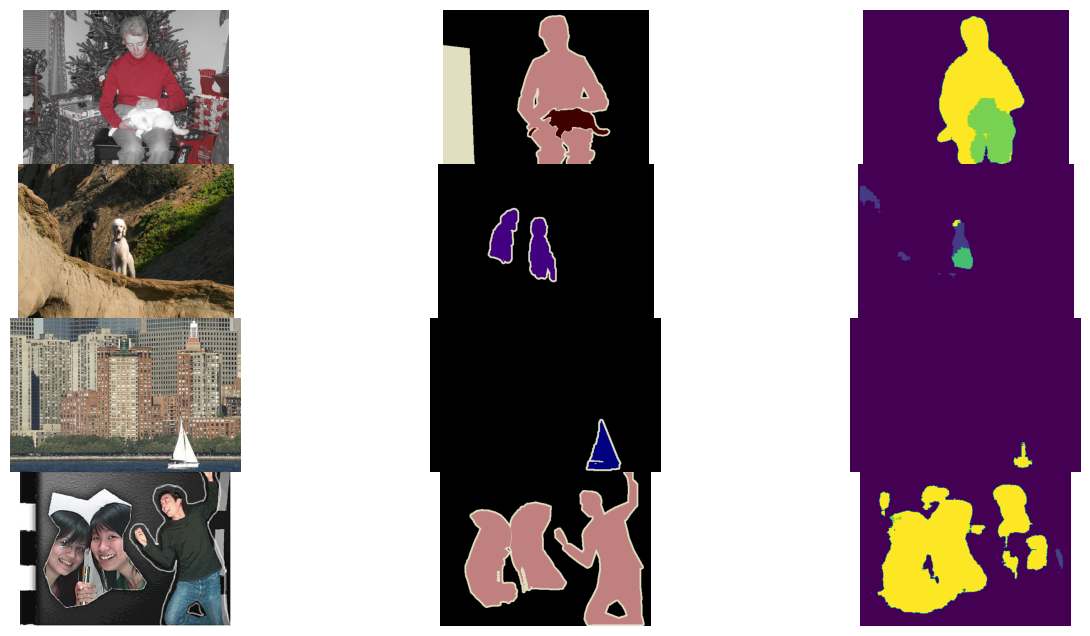

In [18]:
import numpy as np
import cv2
from PIL import Image
from mindspore import Tensor
import mindspore.common.dtype as mstype
import mindspore.nn as nn
from mindspore import context
from mindspore.train.serialization import load_checkpoint, load_param_into_net

data_lst = "./dataset/VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt"
with open(data_lst) as f:
    image = f.readlines()

net = FCN8s(n_class=num_classes)

# 设置超参
ckpt_file = "./ckpt/FCN8s_2-249_2645.ckpt" 
data_root = "./dataset/VOCdevkit/VOC2012"
param_dict = load_checkpoint(ckpt_file)
load_param_into_net(net, param_dict)
eval_batch_size = 4
img_lst = []
for i, line in enumerate(image[100:104]):

    img_name = line.strip('\n')
    data_root = data_root
    img_path = data_root + '/JPEGImages/' + str(img_name) + '.jpg'
    img_ = np.array(Image.open(img_path), dtype=np.uint8)   
    img_lst.append(img_)

res = eval_batch_scales(net, img_lst, scales=[1.0], base_crop_size=512, flip=False)


plt.figure(figsize=(16, 8))
for i, line in enumerate(image[100:104]):
    img_name = line.strip('\n')
    data_root = data_root
    img_path = data_root + '/JPEGImages/' + str(img_name) + '.jpg'
    msk_path = data_root + '/SegmentationClass/' + str(img_name) + '.png'
    img_ = Image.open(img_path)
    msk_ = Image.open(msk_path)
    res_ = res[i]
    plt.subplot(4, 3, i*3+1)
    plt.imshow(img_)
    plt.axis("off")
    plt.subplots_adjust(wspace=0.05, hspace=0)
    plt.subplot(4, 3, i*3+2)
    plt.imshow(msk_)
    plt.axis("off")
    plt.subplots_adjust(wspace=0.05, hspace=0)
    plt.subplot(4, 3, i*3+3)
    plt.imshow(res_);
    plt.axis("off")
    plt.subplots_adjust(wspace=0.05, hspace=0)
 

## 总结
FCN的核心贡献在于提出使用全卷积层，通过学习让图片实现端到端分割。与传统使用CNN进行图像分割的方法相比，FCN有两大明显的优点：一是可以接受任意大小的输入图像，无需要求所有的训练图像和测试图像具有固定的尺寸。二是更加高效，避免了由于使用像素块而带来的重复存储和计算卷积的问题。

同时FCN网络也存在待改进之处：

一是得到的结果仍不够精细。进行8倍上采样虽然比32倍的效果好了很多，但是上采样的结果仍比较模糊和平滑，尤其是边界处，网络对图像中的细节不敏感。
二是对各个像素进行分类，没有充分考虑像素与像素之间的关系（如不连续性和相似性）。忽略了在通常的基于像素分类的分割方法中使用的空间规整（spatial regularization）步骤，缺乏空间一致性。

## 引用
[1]Long, Jonathan, Evan Shelhamer, and Trevor Darrell. "Fully convolutional networks for semantic segmentation." Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition. 2015.